In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from math import floor, ceil
from pylab import rcParams

%matplotlib inline

In [2]:
sns.set(style='ticks', palette='Spectral', font_scale=1.5)

material_palette = ["#4CAF50", "#2196F3", "#9E9E9E", "#FF9800", "#607D8B", "#9C27B0"]
sns.set_palette(material_palette)
rcParams['figure.figsize'] = 16, 8

plt.xkcd();
random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)

## Prepare data

In [298]:
%matplotlib inline
import pandas as pd

brakepads = pd.read_json("data.json")
print(str(brakepads.shape) + ' original shape')
brakepads.dropna(subset=['classOfPart'], how='any', inplace=True)
print(str(brakepads.shape) + ' removed any where class of part is not specified')
brakepads.dropna(thresh=4, inplace=True)
print(str(brakepads.shape) + ' when less 4 or fields are NA (part number is still included)')
brakepads[['classOfPart']].astype('category')
number_of_missing_values = brakepads.isnull().sum().sum()
percent_of_missing_values = number_of_missing_values/(brakepads.shape[0]*(brakepads.shape[1]-1))
print(str(number_of_missing_values) + ' (' + str(percent_of_missing_values) + ' percent) values are missing')

# Remove outliers
brakepads = brakepads.astype({'length': 'float64', 'thickness': 'float64', 'width': 'float64'})
lengthOutliers = brakepads[brakepads.length > 1000].index.values.astype(int)
thicknessOutliers = brakepads[brakepads.thickness > 50].index.values.astype(int)
outliers = list(lengthOutliers) + list(thicknessOutliers)
for i in outliers:
    brakepads = brakepads.drop(i)
print(str(brakepads.shape) + ' final shape')

(4001, 5) original shape
(1440, 5) removed any where class of part is not specified
(1275, 5) when less 4 or fields are NA (part number is still included)
1000 (0.19607843137254902 percent) values are missing
(1273, 5) final shape


In [299]:
brakepads

,partNumber,classOfPart,length,width,thickness
0,402B0788,Hinterachse,108.7,NaN,14.0
5,402B0041,Hinterachse,NaN,93.1,16.0
10,402B0030,Hinterachse,107.8,NaN,12.9
11,402B0462,Hinterachse,NaN,53.8,15.4
15,402B0055,Hinterachse,95.0,NaN,15.8
...,...,...,...,...,...
3983,50-02-224,Vorderachse,120.3,NaN,14.7
3986,ADT34285,Vorderachse,133.2,52.8,17.1
3989,PD28.514,Hinterachse,NaN,110.5,15.5
3990,6712,Hinterachse,NaN,107.7,14.0


#### Impute missing values

In [300]:
import numpy as np
from sklearn.impute import SimpleImputer
imp_simple = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_simple.fit(brakepads[['length', 'thickness', 'width']])
imputed_simple = imp_simple.transform(brakepads[['length', 'thickness', 'width']])
imputed_simple = pd.DataFrame(data=imputed_simple, columns=['length', 'thickness', 'width'])
imputed_simple['classOfPart'] = brakepads['classOfPart'].tolist()
print(imputed_simple.shape)
imputed_simple

(1273, 4)


,length,thickness,width,classOfPart
0,108.700000,14.0,90.487411,Hinterachse
1,121.686603,16.0,93.100000,Hinterachse
2,107.800000,12.9,90.487411,Hinterachse
3,121.686603,15.4,53.800000,Hinterachse
4,95.000000,15.8,90.487411,Hinterachse
...,...,...,...,...
1268,120.300000,14.7,90.487411,Vorderachse
1269,133.200000,17.1,52.800000,Vorderachse
1270,121.686603,15.5,110.500000,Hinterachse
1271,121.686603,14.0,107.700000,Hinterachse


In [301]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

complete = brakepads[['length', 'thickness', 'width']].replace(to_replace='None', value=np.nan).dropna()
imp = IterativeImputer(max_iter=11, random_state=0)
imp.fit(complete)
transformed = pd.DataFrame(imp.transform(brakepads[['length', 'thickness', 'width']]))

# Replace data in original data frame
brakepads['length'] = list(transformed[0])
brakepads['thickness'] = list(transformed[1])
brakepads['width'] = list(transformed[2])

imputed = pd.DataFrame(data=brakepads, columns=['length', 'thickness', 'width'])
imputed['classOfPart'] = brakepads['classOfPart'].tolist()

print(imputed.shape)
imputed

(1273, 4)


,length,thickness,width,classOfPart
0,108.700000,14.0,64.249927,Hinterachse
5,124.709055,16.0,93.100000,Hinterachse
10,107.800000,12.9,64.249927,Hinterachse
11,124.709055,15.4,53.800000,Hinterachse
15,95.000000,15.8,64.249927,Hinterachse
...,...,...,...,...
3983,120.300000,14.7,64.249927,Vorderachse
3986,133.200000,17.1,52.800000,Vorderachse
3989,124.709055,15.5,110.500000,Hinterachse
3990,124.709055,14.0,107.700000,Hinterachse


## Exploration

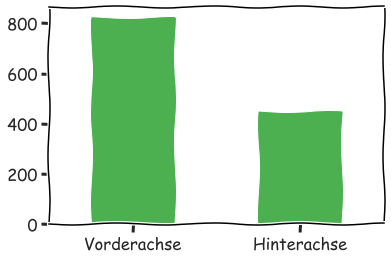

In [302]:
imputed.classOfPart.value_counts().plot(kind="bar", rot=0)

In [303]:
imputed.classOfPart.value_counts(normalize=True)

Vorderachse    0.64729
Hinterachse    0.35271
Name: classOfPart, dtype: float64

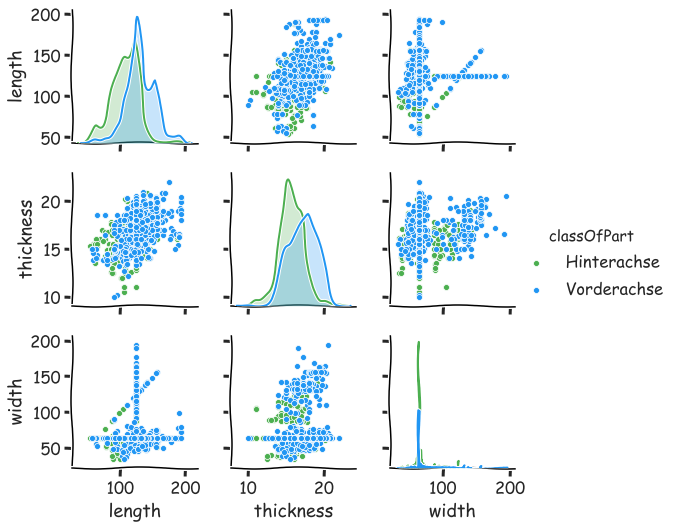

In [304]:
sns.pairplot(imputed[['length', 'thickness', 'width', 'classOfPart']], hue='classOfPart');

## Build NN Model

In [305]:
from sklearn.model_selection import train_test_split

def encode(series): 
  return pd.get_dummies(series.astype(str))

# cleaned = cleaned.sample(frac=1)
X = imputed[['length', 'thickness', 'width']].to_numpy()
# train_y = encode(cleaned.classOfPart)
y = imputed.classOfPart
y = y.replace("Hinterachse", 0)
y = y.replace("Vorderachse", 1)
y = y.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)
# random_state=42

In [306]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(3, activation='relu'),
  tf.keras.layers.Dropout(0.15),
  tf.keras.layers.Dense(9, activation='relu'),
  tf.keras.layers.Dense(18, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])
# Dropout: Consists in randomly setting a fraction `rate` of input units to 0 at each update training time to prevent overfitting.
# Dense: Just your regular densely-connected NN layer

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [308]:
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    model.fit(X_train, y_train, epochs=250, verbose=0, validation_split=0)
    print(model.evaluate(X_test, y_test, verbose=2))

255/1 - 0s - loss: 0.6429 - accuracy: 0.6471
[0.6355640829778185, 0.64705884]
255/1 - 0s - loss: 0.6516 - accuracy: 0.5490
[0.67563329187094, 0.54901963]
255/1 - 0s - loss: 0.7075 - accuracy: 0.5961
[0.6649359632940853, 0.59607846]
255/1 - 0s - loss: 0.7092 - accuracy: 0.6941
[0.6696528948989569, 0.69411767]
255/1 - 0s - loss: 0.5751 - accuracy: 0.6471
[0.6079427805601382, 0.64705884]
255/1 - 0s - loss: 0.5646 - accuracy: 0.6784
[0.5860613640616922, 0.6784314]
255/1 - 0s - loss: 0.5612 - accuracy: 0.6902
[0.5648509135433272, 0.6901961]
255/1 - 0s - loss: 0.7407 - accuracy: 0.5725
[0.6801250843440785, 0.57254905]
255/1 - 0s - loss: 0.5443 - accuracy: 0.6980
[0.5534653268608393, 0.69803923]
255/1 - 0s - loss: 0.8591 - accuracy: 0.5216
[0.7452895501080681, 0.52156866]


## Build kNN Model

In [349]:
from sklearn import neighbors, datasets
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [324]:
X = imputed[['length', 'thickness', 'width']].to_numpy()
y = imputed.classOfPart
y = y.replace("Hinterachse", 0)
y = y.replace("Vorderachse", 1)
y = y.to_numpy()

In [390]:
def apply_knn(X_train, X_test, y_train, y_test):
    n_neighbors = 4
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
    clf.fit(X_train, y_train)
    return accuracy_score(y_test, clf.predict(X_test))

def apply_logistic_regression(X_train, X_test, y_train, y_test):
    tau = 0.5
    clf = LogisticRegression(C=tau)
    clf.fit(X_train, y_train)
    return accuracy_score(y_test, clf.predict(X_test))

def apply_random_forest(X_train, X_test, y_train, y_test):
    number_of_decision_trees = 50
    considered_attributes_per_node = 2 
    clf = RandomForestClassifier(n_estimators=number_of_decision_trees, max_features=considered_attributes_per_node)
    clf.fit(X_train, y_train)
    return accuracy_score(y_test, clf.predict(X_test))

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(3, activation='relu'),
  tf.keras.layers.Dropout(0.15),
  tf.keras.layers.Dense(9, activation='relu'),
  tf.keras.layers.Dense(18, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

def apply_neural_network(X_train, X_test, y_train, y_test):
    number_of_steps = 50
    model.fit(X_train, y_train, epochs=number_of_steps, verbose=0, validation_split=0)
    return model.evaluate(X_test, y_test, verbose=0)[1]

In [391]:
results = pd.DataFrame(columns=['kNN', 'LR', 'RF', 'NN'])
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    kNN_result = apply_knn(X_train, X_test, y_train, y_test)
    logistic_regression_result = apply_logistic_regression(X_train, X_test, y_train, y_test)
    random_forest_result = apply_random_forest(X_train, X_test, y_train, y_test)
    neural_network_result = apply_neural_network(X_train, X_test, y_train, y_test)
    results = results.append([{ 'kNN': kNN_result, 'LR': logistic_regression_result, 'RF': random_forest_result, 'NN': neural_network_result }])

In [392]:
results.describe()

,kNN,LR,RF,NN
count,100.000000,100.000000,100.000000,100.000000
mean,0.844667,0.727020,0.851686,0.658118
std,0.021062,0.025796,0.020369,0.062304
min,0.780392,0.631373,0.792157,0.517647
25%,0.834314,0.709804,0.839216,0.607843
50%,0.847059,0.725490,0.850980,0.658824
75%,0.858824,0.741176,0.866667,0.706863
max,0.898039,0.784314,0.894118,0.780392


In [393]:
results.to_csv('./results.csv')

In [394]:
#        kNN     LR     RF     NN
# kNN     NA 0.0000 0.0707 0.0000
# LR  0.0000     NA 0.0000 0.0043
# RF  0.0707 0.0000     NA 0.0000
# NN  0.0000 0.0043 0.0000     NA

#   kNN    LR    RF    NN 
# "a  " " b " "a  " "  c" 

In [145]:
# earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='min')
mcp_save = tf.keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_accuracy', mode='min')
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=7, verbose=0, min_delta=1e-4, mode='min')
history = model.fit(X, y, epochs=100, verbose=0, callbacks=[mcp_save, reduce_lr_loss], validation_split=0.1)

model.load_weights(filepath = '.mdl_wts.hdf5')

score = model.evaluate(X_test, y_test, verbose=2)
print('CV loss:', score[0])
print('CV accuracy:', score[1])

# pt = model.predict(X)
# mse = (np.mean((pt-X_test.to_numpy())**2))
# print('CV MSE: ', mse)
    
# predA_test = model.predict(X_test.to_numpy()) # Here, we make the predictions for use in pseudo-labellin

## Not Used Anymore

In [12]:
def encode(series): 
  return pd.get_dummies(series.astype(str))

train_x = cleaned[['length', 'thickness', 'width']]
# train_y = encode(cleaned.classOfPart)
train_y = cleaned.classOfPart


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.1, random_state=42)


model = tf.keras.Sequential() # Linear stack of layers
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(2, activation='relu'))


def multilayer_perceptron(x, weights, biases, keep_prob):
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_1 = tf.nn.dropout(layer_1, keep_prob)
    out_layer = tf.matmul(layer_1, weights['out']) + biases['out']
    return out_layer


n_hidden_1 = 5
n_input = train_x.shape[1]
n_classes = train_y.shape[0]

weights = {
    'h1': tf.Variable(tf.random.normal([n_input, n_hidden_1])),
    'out': tf.Variable(tf.random.normal([n_hidden_1, n_classes]))
}

biases = {
    'b1': tf.Variable(tf.random.normal([n_hidden_1])),
    'out': tf.Variable(tf.random.normal([n_classes]))
}

keep_prob = tf.Variable(tf.ones(shape=(2))) # Potential error


training_epochs = 5000
display_step = 1000
batch_size = 32

# x = tf.Variable(tf.ones(shape=(None, n_input)))
# y = tf.placeholder(tf.ones(shape=(None, n_classes)))


from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow

import tensorflow as tf


mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0


model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test,  y_test, verbose=2)